In [35]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import data_util

In [36]:
s_stocks=data_util.stock_data('SPY',4,'SPY')
# plot(apple_stocks,'Apple')  

[*********************100%%**********************]  1 of 1 completed


In [37]:
stocks = s_stocks[['Close']].copy()

In [38]:
test_Results=adfuller(stocks["Close"])
print("p-value of the Test",test_Results[1])

p-value of the Test 0.34509212656817134


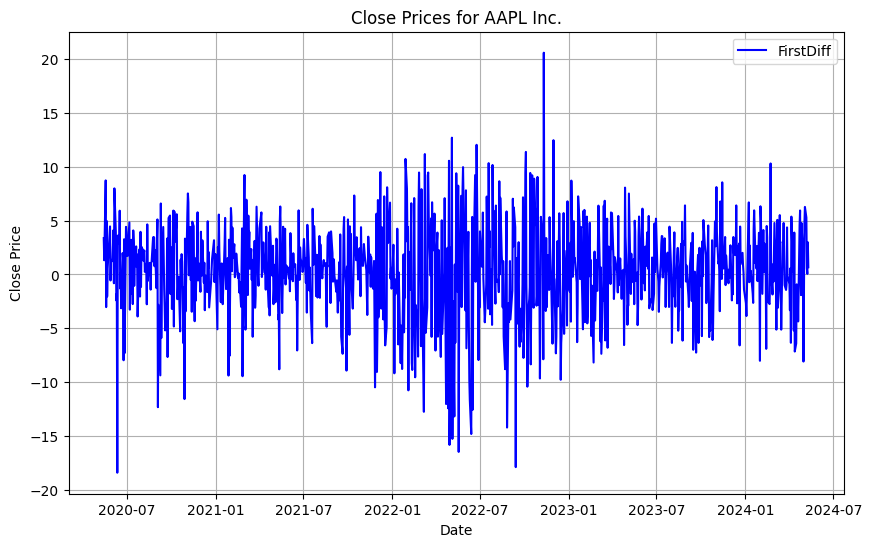

In [39]:
stocks['FirstDiff'] = stocks['Close'].diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(stocks.index, stocks['FirstDiff'], color='blue', label='FirstDiff')
plt.title(f'Close Prices for {"AAPL"} Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()  
plt.grid(True)
plt.show()

In [40]:
test_Results=adfuller(stocks["FirstDiff"][1:])#first entry will be Nan
print("p-value of the Test",test_Results[1])

p-value of the Test 0.0


In [41]:
from pmdarima.arima.utils import ndiffs

d = ndiffs(stocks["Close"])

print("No. of differences needed:", d)

No. of differences needed: 1


<BarContainer object of 30 artists>

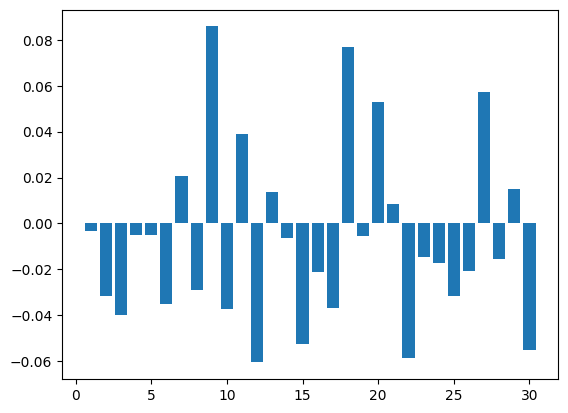

In [42]:
acf_vals = acf(stocks['FirstDiff'][1:])
plt.bar(range(1,acf_vals.shape[0]), acf_vals[1:acf_vals.shape[0]])
# acf_vals.shape

<BarContainer object of 30 artists>

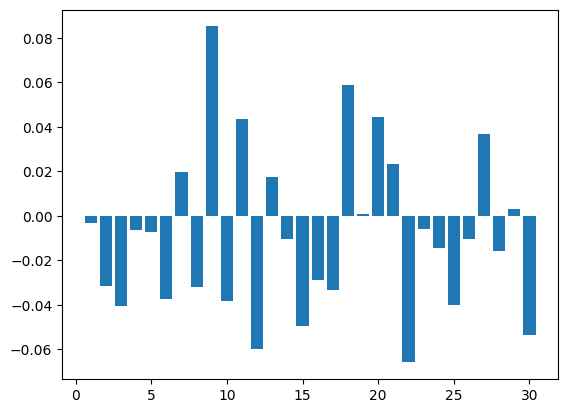

In [43]:
pacf_vals = pacf(stocks['FirstDiff'][1:])
plt.bar(range(1,pacf_vals.shape[0]), pacf_vals[1:pacf_vals.shape[0]])

In [44]:
train=pd.DataFrame(stocks['Close'][0:int(len(stocks)*0.70)])
test=pd.DataFrame(stocks['Close'][int(len(stocks)*0.70):])


In [45]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train, order=(3,1,3))
# model = ARIMA(stocks['FirstDiff'][1:], order=(2,0,2))

model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  704
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2088.386
Date:                Mon, 13 May 2024   AIC                           4190.773
Time:                        06:06:48   BIC                           4222.660
Sample:                             0   HQIC                          4203.097
                                - 704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2178      0.120      1.812      0.070      -0.018       0.454
ar.L2         -0.3445      0.083     -4.148      0.000      -0.507      -0.182
ar.L3          0.8847      0.116      7.606      0.0

(array([0.00257652, 0.00404882, 0.01325067, 0.04085624, 0.08833781,
        0.07729558, 0.02576519, 0.00625726, 0.        , 0.00036807]),
 array([-18.08223813, -14.21759578, -10.35295343,  -6.48831108,
         -2.62366872,   1.24097363,   5.10561598,   8.97025833,
         12.83490069,  16.69954304,  20.56418539]),
 <BarContainer object of 10 artists>)

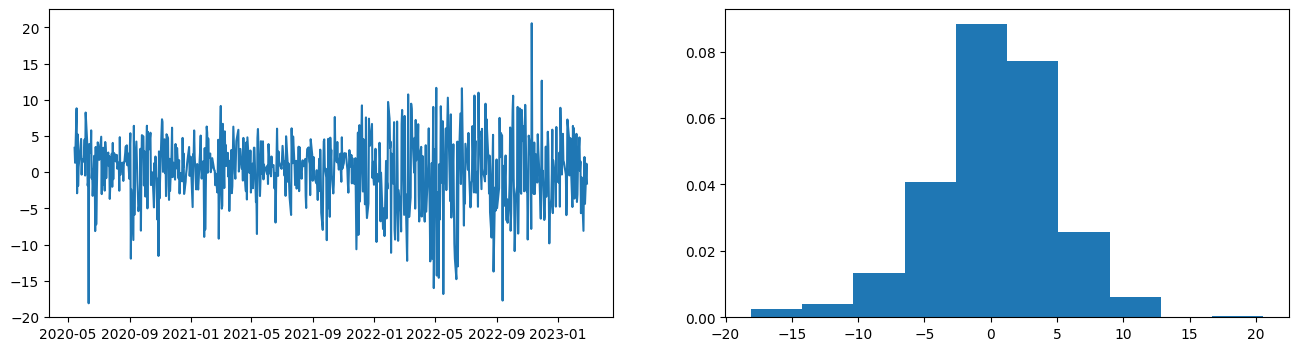

In [46]:
residuals = pd.DataFrame(model_fit.resid[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)

ax2.hist(residuals, density=True)

In [47]:
predictions = model_fit.forecast(len(test))

dates = test.index.tolist()  # Convert index to list of dates
predictions = predictions.tolist()  # Convert predicted values to list

# Create a DataFrame using the lists of dates and predictions
predicted_df = pd.DataFrame({'Predicted_Value': predictions}, index=dates)

# Print the DataFrame
print(predicted_df)



            Predicted_Value
2023-03-01       396.376119
2023-03-02       396.533570
2023-03-03       396.645313
2023-03-06       396.718137
2023-03-07       396.834803
...                     ...
2024-05-06       397.771474
2024-05-07       397.771893
2024-05-08       397.771361
2024-05-09       397.771321
2024-05-10       397.771866

[302 rows x 1 columns]


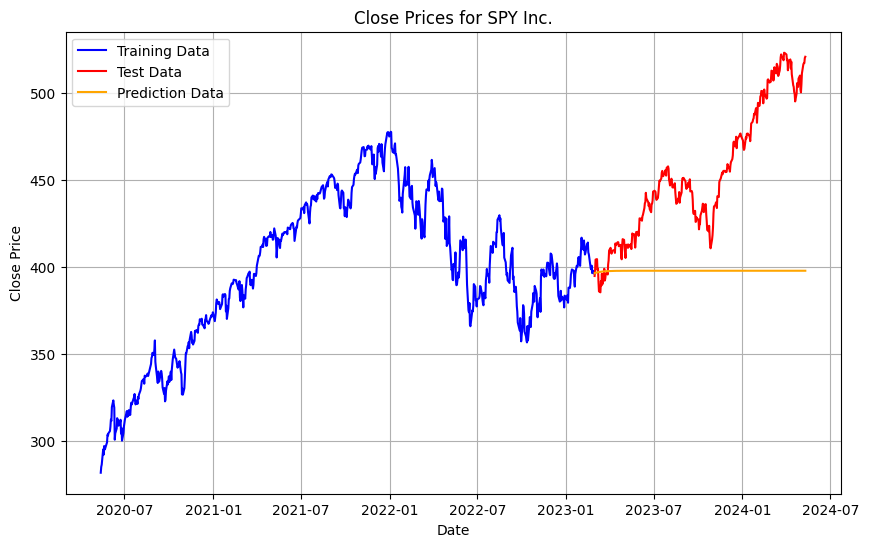

In [48]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(predicted_df.index, predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for SPY Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import warnings
warnings.filterwarnings("ignore")
rolling=int(len(stocks)*0.70)
train=pd.DataFrame(stocks['Close'][0:rolling])
test=pd.DataFrame(stocks['Close'][rolling:])
predictions_rolling=[]
for i in range(len(test)):
    try:
        model = ARIMA(train, order=(3,1,3))
        model_fit = model.fit()
        pred=model_fit.forecast()
        # if(pred<0):
        #     predictions_rolling.append(stocks['Close'][rolling])

        predictions_rolling.append(pred)
        print(float(pred),test['Close'][i])
    except:
        predictions_rolling.append(stocks['Close'][rolling])
        print("Singular Matrix found")
    rolling+=1
    train=pd.DataFrame(stocks['Close'][0:rolling])
print(predictions_rolling)

396.3761192744288 394.739990234375
394.7471172367999 397.80999755859375
397.8555020514622 404.19000244140625
404.25384171879926 404.4700012207031
404.4419050495136 398.2699890136719
398.18893873284884 398.9200134277344
399.10867598680176 391.55999755859375
391.91710325813085 385.9100036621094
386.067207570276 385.3599853515625
385.8089742471302 391.7300109863281
392.10613773823206 389.2799987792969
389.3528832127627 396.1099853515625
395.91076095610373 389.989990234375
390.14462472903944 393.739990234375
393.4515608728136 398.9100036621094
398.9504847135221 392.1099853515625
392.0864663035432 393.1700134277344
392.9282286474759 395.75
395.90891038002644 396.489990234375
396.4743167294439 395.6000061035156
395.3762332325003 401.3500061035156
401.2071559520013 403.70001220703125
403.5809412998742 409.3900146484375
408.9290517705627 410.95001220703125
410.61116370720106 408.6700134277344
408.3820104063586 407.6000061035156
407.3861481696299 409.19000244140625
409.1208344921289 409.6099853

In [54]:
# predictions_rolling=[float(i) for i in predictions_rolling]
pr=[]
for i in range(len(predictions_rolling)):
    if (float(predictions_rolling[i])<0):
        pr.append(float(stocks['Close'][i]))
    else:
        pr.append(float(predictions_rolling[i]))
predictions_rolling=pr

In [55]:

dates = test.index.tolist()

rolling_predicted_df = pd.DataFrame({'Predicted_Value': predictions_rolling}, index=dates)

# Print the DataFrame
print(rolling_predicted_df)


            Predicted_Value
2023-03-01       396.376119
2023-03-02       394.747117
2023-03-03       397.855502
2023-03-06       404.253842
2023-03-07       404.441905
...                     ...
2024-05-06       511.114289
2024-05-07       516.536937
2024-05-08       517.027104
2024-05-09       517.248419
2024-05-10       520.315507

[302 rows x 1 columns]


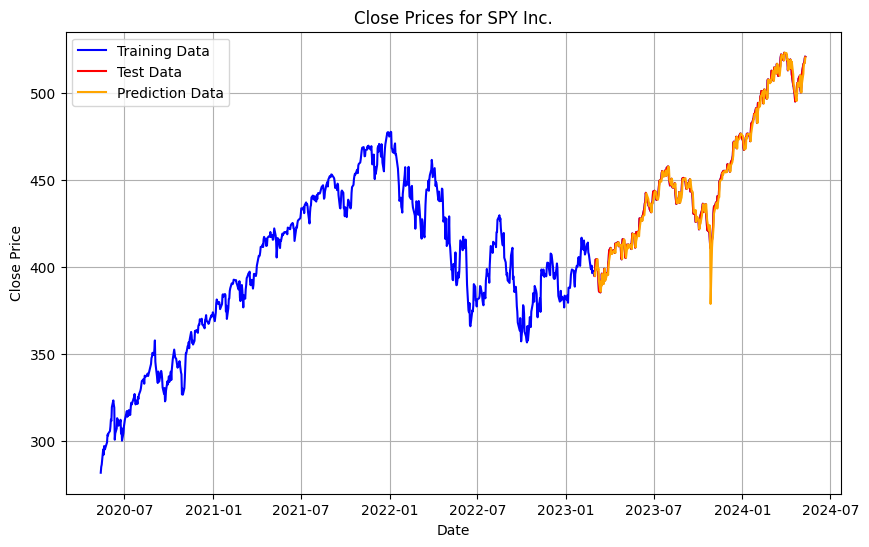

In [56]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(test.index.tolist(), predictions_rolling, color='orange', label='Prediction Data')
# plt.plot(rolling_predicted_df.index, rolling_predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for SPY Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

In [58]:
y_true=test["Close"].values
y_pred=rolling_predicted_df["Predicted_Value"].values
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

,Metric,Value
0,MAPE,0.64
1,MAE,2.84
2,MSE,15.54
3,RMSE,3.94
4,R2,0.99
5,SMAPE,0.64
